In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# Data import
with pd.HDFStore('MiningProcess_Flotation_Plant_Database_train_split.h5') as store:
    X_cal = store.get('X_cal')
    Y_cal = store.get('Y_cal')
    X_test = store.get('X_test')
    Y_test = store.get('Y_test')

# Calibration and validation

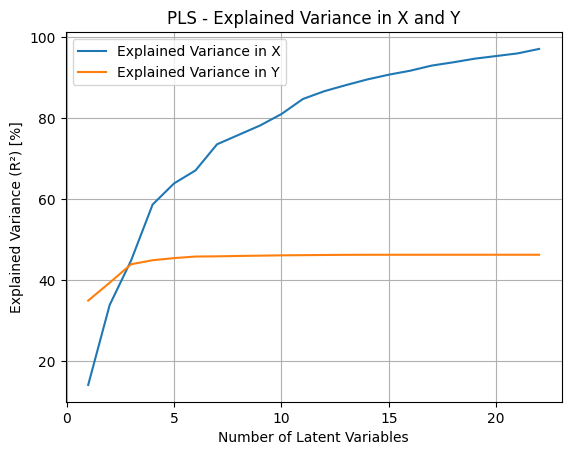

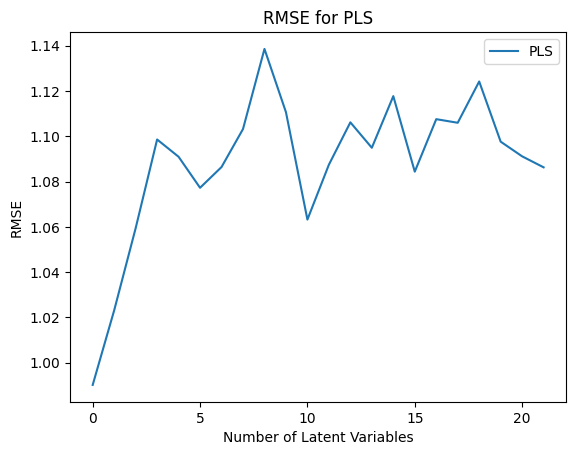

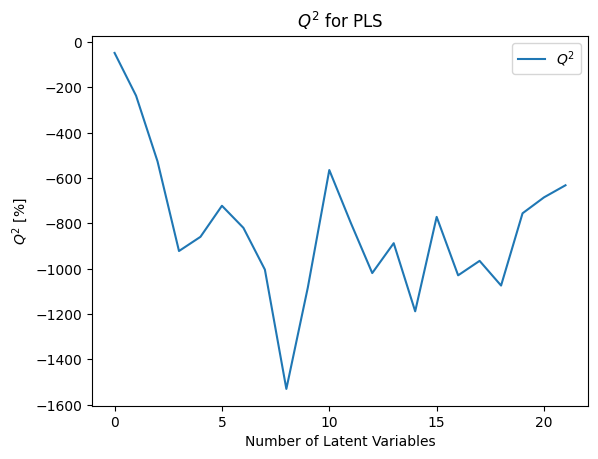

Optimal number of components for PLS: 1
Test RMSE for PLS: 0.9235979868889869


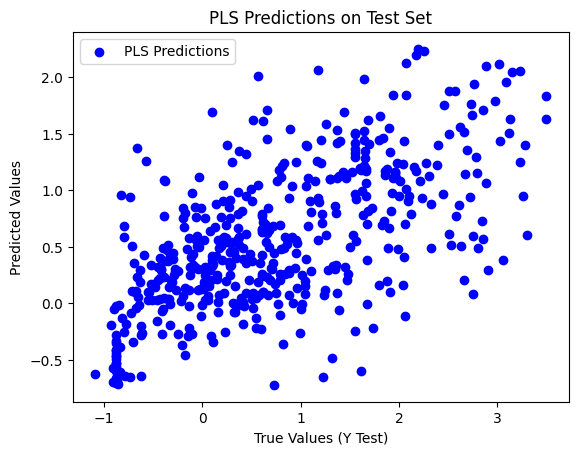

In [2]:
# Standardize X_cal and apply the same transformation to X_test
scaler = StandardScaler()
X_cal_scaled = scaler.fit_transform(X_cal)
X_test_scaled = scaler.transform(X_test)

# Center Y_cal and apply the same transformation to Y_test
Y_cal_mean = np.mean(Y_cal)
Y_cal_centered = Y_cal - Y_cal_mean
Y_test_centered = Y_test - Y_cal_mean

# PLS Regression
pls = PLSRegression(n_components=22)
pls.fit(X_cal_scaled, Y_cal_centered)

# Calculate R2 for both X and Y for each component
R2_X_PLS = np.zeros(22)
R2_Y_PLS = np.zeros(22)

for j in range(1, 23):
    pls_temp = PLSRegression(n_components=j)
    pls_temp.fit(X_cal_scaled, Y_cal_centered)
    
    # Explained variance for X
    X_scores = pls_temp.x_scores_
    X_reconstructed = X_scores @ pls_temp.x_loadings_.T
    R2_X_PLS[j-1] = 1 - np.sum((X_cal_scaled - X_reconstructed) ** 2) / np.sum(X_cal_scaled ** 2)
    
    # Explained variance for Y
    R2_Y_PLS[j-1] = pls_temp.score(X_cal_scaled, Y_cal_centered)

# Plot R^2 values for PLS
plt.figure()
plt.plot(np.arange(1, 23), R2_X_PLS * 100, label='Explained Variance in X')
plt.plot(np.arange(1, 23), R2_Y_PLS * 100, label='Explained Variance in Y')
plt.title('PLS - Explained Variance in X and Y')
plt.xlabel('Number of Latent Variables')
plt.ylabel('Explained Variance (R²) [%]')
plt.legend()
plt.grid(True)
plt.show()

# TimeSeriesSplit for cross-validation
k = 10
tscv = TimeSeriesSplit(n_splits=k)

RMSEPLS = np.zeros((k, 22))
Q2PLS = np.zeros((22,))

SST_Y_cal = np.sum(Y_cal_centered ** 2)

for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(X_cal)):
    X_fold_cal, X_fold_val = X_cal.iloc[train_idx], X_cal.iloc[val_idx]
    Y_fold_cal, Y_fold_val = Y_cal.iloc[train_idx], Y_cal.iloc[val_idx]
    
    # Scale the training and validation sets
    scaler_fold = StandardScaler()
    X_fold_cal_scaled = scaler_fold.fit_transform(X_fold_cal)
    X_fold_val_scaled = scaler_fold.transform(X_fold_val)
    
    Y_fold_cal_mean = np.mean(Y_fold_cal)
    Y_fold_cal_centered = Y_fold_cal - Y_fold_cal_mean
    Y_fold_val_centered = Y_fold_val - Y_fold_cal_mean

    for j in range(1, 23):        
        # PLS
        pls_fold = PLSRegression(n_components=j)
        pls_fold.fit(X_fold_cal_scaled, Y_fold_cal_centered)
        Y_pred_val_pls = pls_fold.predict(X_fold_val_scaled).flatten()
        RMSEPLS[fold_idx, j-1] = np.sqrt(root_mean_squared_error(Y_fold_val_centered, Y_pred_val_pls))

        # Update Q^2 calculation: 1 - (SSE/SST)
        SSE_fold = np.sum((Y_fold_val_centered - Y_pred_val_pls) ** 2)
        Q2PLS[j-1] += (1 - SSE_fold / np.sum(Y_fold_val_centered ** 2)) / k

# Average RMSE over all folds
RMSE_CV_PLS = np.mean(RMSEPLS, axis=0)

# Plot RMSE for PLS
plt.figure()
plt.plot(RMSE_CV_PLS, label='PLS')
plt.title('RMSE for PLS')
plt.xlabel('Number of Latent Variables')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Plot Q^2 for PLS
plt.figure()
plt.plot(Q2PLS * 100, label='$Q^2$')
plt.title('$Q^2$ for PLS')
plt.xlabel('Number of Latent Variables')
plt.ylabel('$Q^2$ [%]')
plt.legend()
plt.show()

# Optimal number of components based on RMSE
optimal_pls_components = np.argmin(RMSE_CV_PLS) + 1
print(f"Optimal number of components for PLS: {optimal_pls_components}")

# Re-calibrate the model with optimal components
pls_optimal = PLSRegression(n_components=optimal_pls_components)
pls_optimal.fit(X_cal_scaled, Y_cal_centered)

# Test set prediction
Y_test_pred_pls = pls_optimal.predict(X_test_scaled).flatten()

# Evaluate on test set
rmse_test_pls = np.sqrt(root_mean_squared_error(Y_test_centered, Y_test_pred_pls))

print(f"Test RMSE for PLS: {rmse_test_pls}")

# Plot the test predictions for PLS
plt.figure()
plt.scatter(Y_test_centered, Y_test_pred_pls, c='blue', label='PLS Predictions')
plt.xlabel('True Values (Y Test)')
plt.ylabel('Predicted Values')
plt.title('PLS Predictions on Test Set')
plt.legend()
plt.show()
